# Make MasterFlat CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 23th 2017

### This notebook does the calibration
-----------------------------------------
- Subtract some background
- the corrected images are saved

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__
from astropy.modeling import models
from ccdproc import CCDData, Combiner

ccdproc version 1.0.1


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
from IPython.display import Image, display

In [7]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [8]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [10]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

In [11]:
inputdarkfile="MasterDark_CTIO_20170118.fits"

In [12]:
outputflatfile="MasterFlat_CTIO_20170118.fits"

In [13]:
def bn_median(masked_array, axis=None):
    """
    Perform fast median on masked array
    
    Parameters
    ----------
    
    masked_array : `numpy.ma.masked_array`
        Array of which to find the median.
    
    axis : int, optional
        Axis along which to perform the median. Default is to find the median of
        the flattened array.
    """
    data = masked_array.filled(fill_value=np.NaN)
    med = bn.nanmedian(data, axis=axis)
    # construct a masked array result, setting the mask from any NaN entries
    return np.ma.array(med, mask=np.isnan(med))

In [14]:
def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)

In [15]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

## Open Master Bias
===============================

In [16]:
master_bias = ccdproc.CCDData.read(inputdarkfile,unit=u.adu)

## Location of Overscan and Trimmed flats
----------------------------------------------------

In [17]:
rootpath_rawimage="./trim_images"
object_name='Flat'

In [18]:
dirlist_all=os.listdir(rootpath_rawimage) 

In [19]:
#if '.DS_Store' in dirlist_all:
#    dirlist_all.remove('.DS_Store')
dirlist=[]
dirlist.append(rootpath_rawimage)
dirlist_all=np.array(dirlist)

In [20]:
print dirlist_all

['./trim_images']


In [21]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [22]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image       
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search('^trim_20170118_([0-9]+).fits$',filename):  #example of filename filter
                    str_index=re.findall('^trim_20170118_([0-9]+).fits$',filename)
                    count=count+1
                    index=int(str_index[0])
                    indexes_files.append(index)         
                    shortfilename=dir_leaf+'/'+filename
                    filelist_fitsimages.append(shortfilename)
                    
    return

In [23]:
MakeFileList()   # Make the list

In [24]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [25]:
print len(indexes_files)

10


In [26]:
print len(filelist_fitsimages)

10


In [27]:
print indexes_files

[205 206 207 208 209 210 211 212 213 214]


In [28]:
len(indexes_files)

10

In [29]:
filelist_fitsimages

array(['./trim_images/trim_20170118_205.fits',
       './trim_images/trim_20170118_206.fits',
       './trim_images/trim_20170118_207.fits',
       './trim_images/trim_20170118_208.fits',
       './trim_images/trim_20170118_209.fits',
       './trim_images/trim_20170118_210.fits',
       './trim_images/trim_20170118_211.fits',
       './trim_images/trim_20170118_212.fits',
       './trim_images/trim_20170118_213.fits',
       './trim_images/trim_20170118_214.fits'], 
      dtype='|S36')

In [30]:
len(filelist_fitsimages)

10

In [31]:
#sorted_dates=np.argsort(filelist_fitsimages)

In [32]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [33]:
sorted_indexes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
#print sorted_dates

In [35]:
print sorted_indexes

[0 1 2 3 4 5 6 7 8 9]


In [36]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [37]:
#sorted_numbers= [indexes_files[index] for index in sorted_indexes]
sorted_numbers=indexes_files[sorted_indexes]

In [38]:
sorted_numbers

array([205, 206, 207, 208, 209, 210, 211, 212, 213, 214])

In [39]:
sorted_files

array(['./trim_images/trim_20170118_205.fits',
       './trim_images/trim_20170118_206.fits',
       './trim_images/trim_20170118_207.fits',
       './trim_images/trim_20170118_208.fits',
       './trim_images/trim_20170118_209.fits',
       './trim_images/trim_20170118_210.fits',
       './trim_images/trim_20170118_211.fits',
       './trim_images/trim_20170118_212.fits',
       './trim_images/trim_20170118_213.fits',
       './trim_images/trim_20170118_214.fits'], 
      dtype='|S36')

## Build full filename
----------------------------

In [40]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(rootpath_rawimage,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [41]:
sorted_filenames=np.array(sorted_filenames)

In [42]:
sorted_filenames

array(['./trim_images/trim_20170118_205.fits',
       './trim_images/trim_20170118_206.fits',
       './trim_images/trim_20170118_207.fits',
       './trim_images/trim_20170118_208.fits',
       './trim_images/trim_20170118_209.fits',
       './trim_images/trim_20170118_210.fits',
       './trim_images/trim_20170118_211.fits',
       './trim_images/trim_20170118_212.fits',
       './trim_images/trim_20170118_213.fits',
       './trim_images/trim_20170118_214.fits'], 
      dtype='|S36')

## Acces to data of  images
----------------------------------

In [43]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [44]:
def BuildRawImages():
    """
    BuildRawImages
    ===============
    """

    global all_dates
    global all_airmass
    global all_images
    global all_titles
    global all_header
    global all_img 
    global sorted_filenames

    for idx,file in np.ndenumerate(sorted_filenames):   
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        num=sorted_numbers[idx[0]]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        hdu_list.close()

In [45]:
BuildRawImages()

## Show images
-----------------------

In [46]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    global all_images
    global all_titles
    global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1

    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        im=axarr[iy,ix].imshow(all_images[index],vmin=0,vmax=35000.)
        axarr[iy,ix].set_title(all_titles[index])
    title='Raw images of '.format(object_name)
    plt.suptitle(title,size=16)        

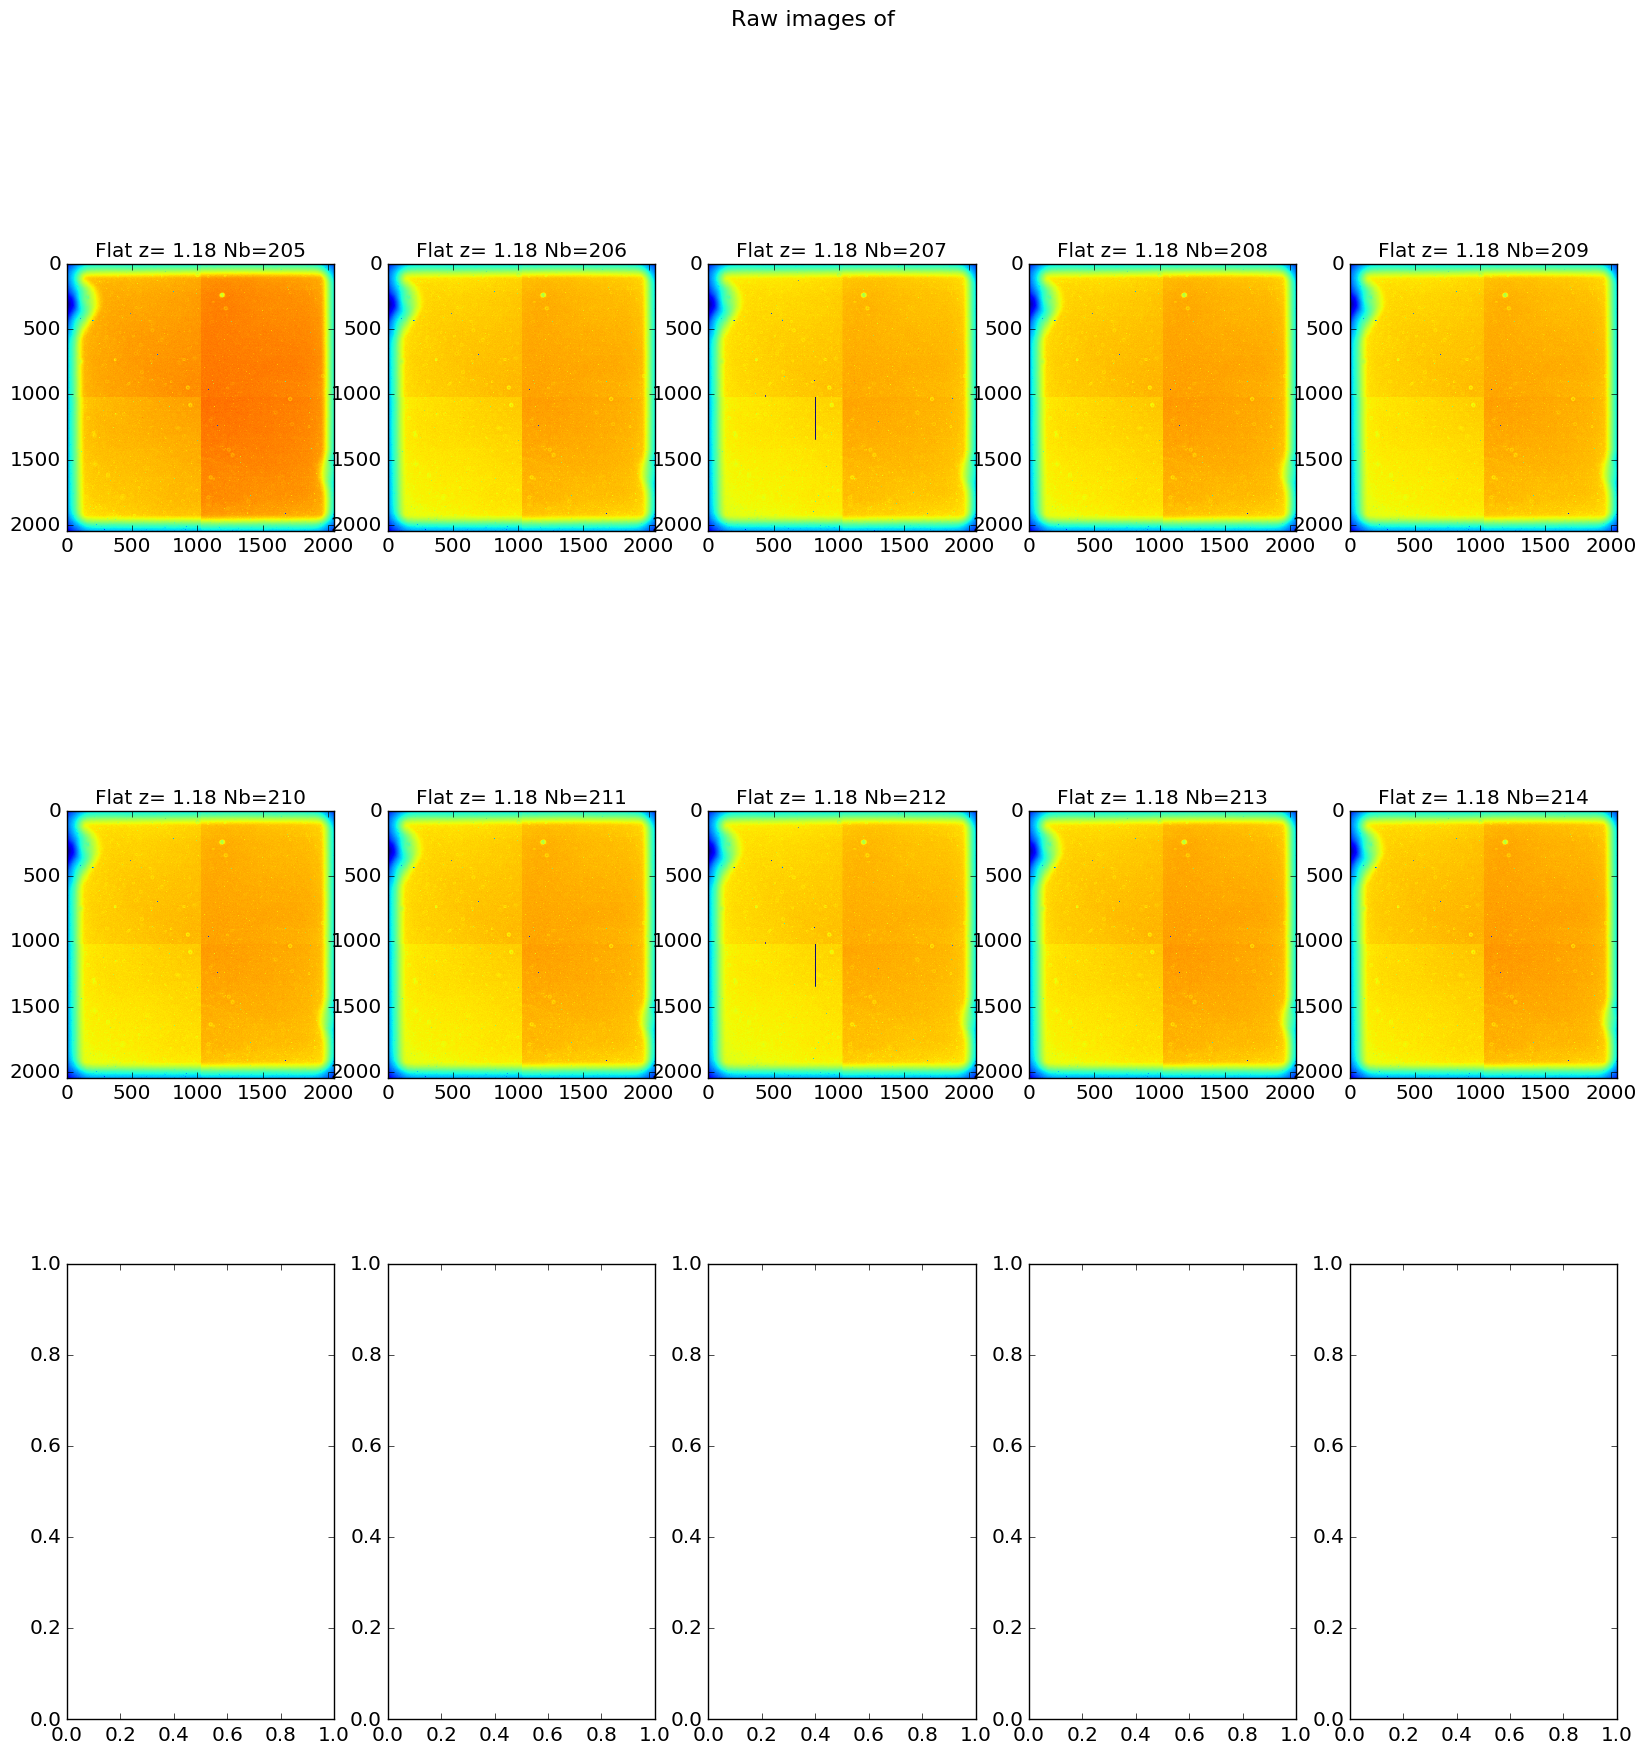

In [47]:
ShowRawImages()

## Show histograms
===========================

In [48]:
def ShowHistograms():
    """
    ShowHistograms
    ==============
    """
    global all_images
    global all_titles
    global object_name


    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        image_flat=all_images[index].flatten()
        stat_mean=image_flat.mean()
        stat_rms=image_flat.std()
        legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
        axarr[iy,ix].hist(image_flat,bins=100,range=(-50,50000.),facecolor='blue', alpha=0.75,label=legtitle);
        axarr[iy,ix].set_yscale('log')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,1e10)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].legend(loc='best')  #useless
    title='histo of images '.format(object_name)
    plt.suptitle(title,size=16)        

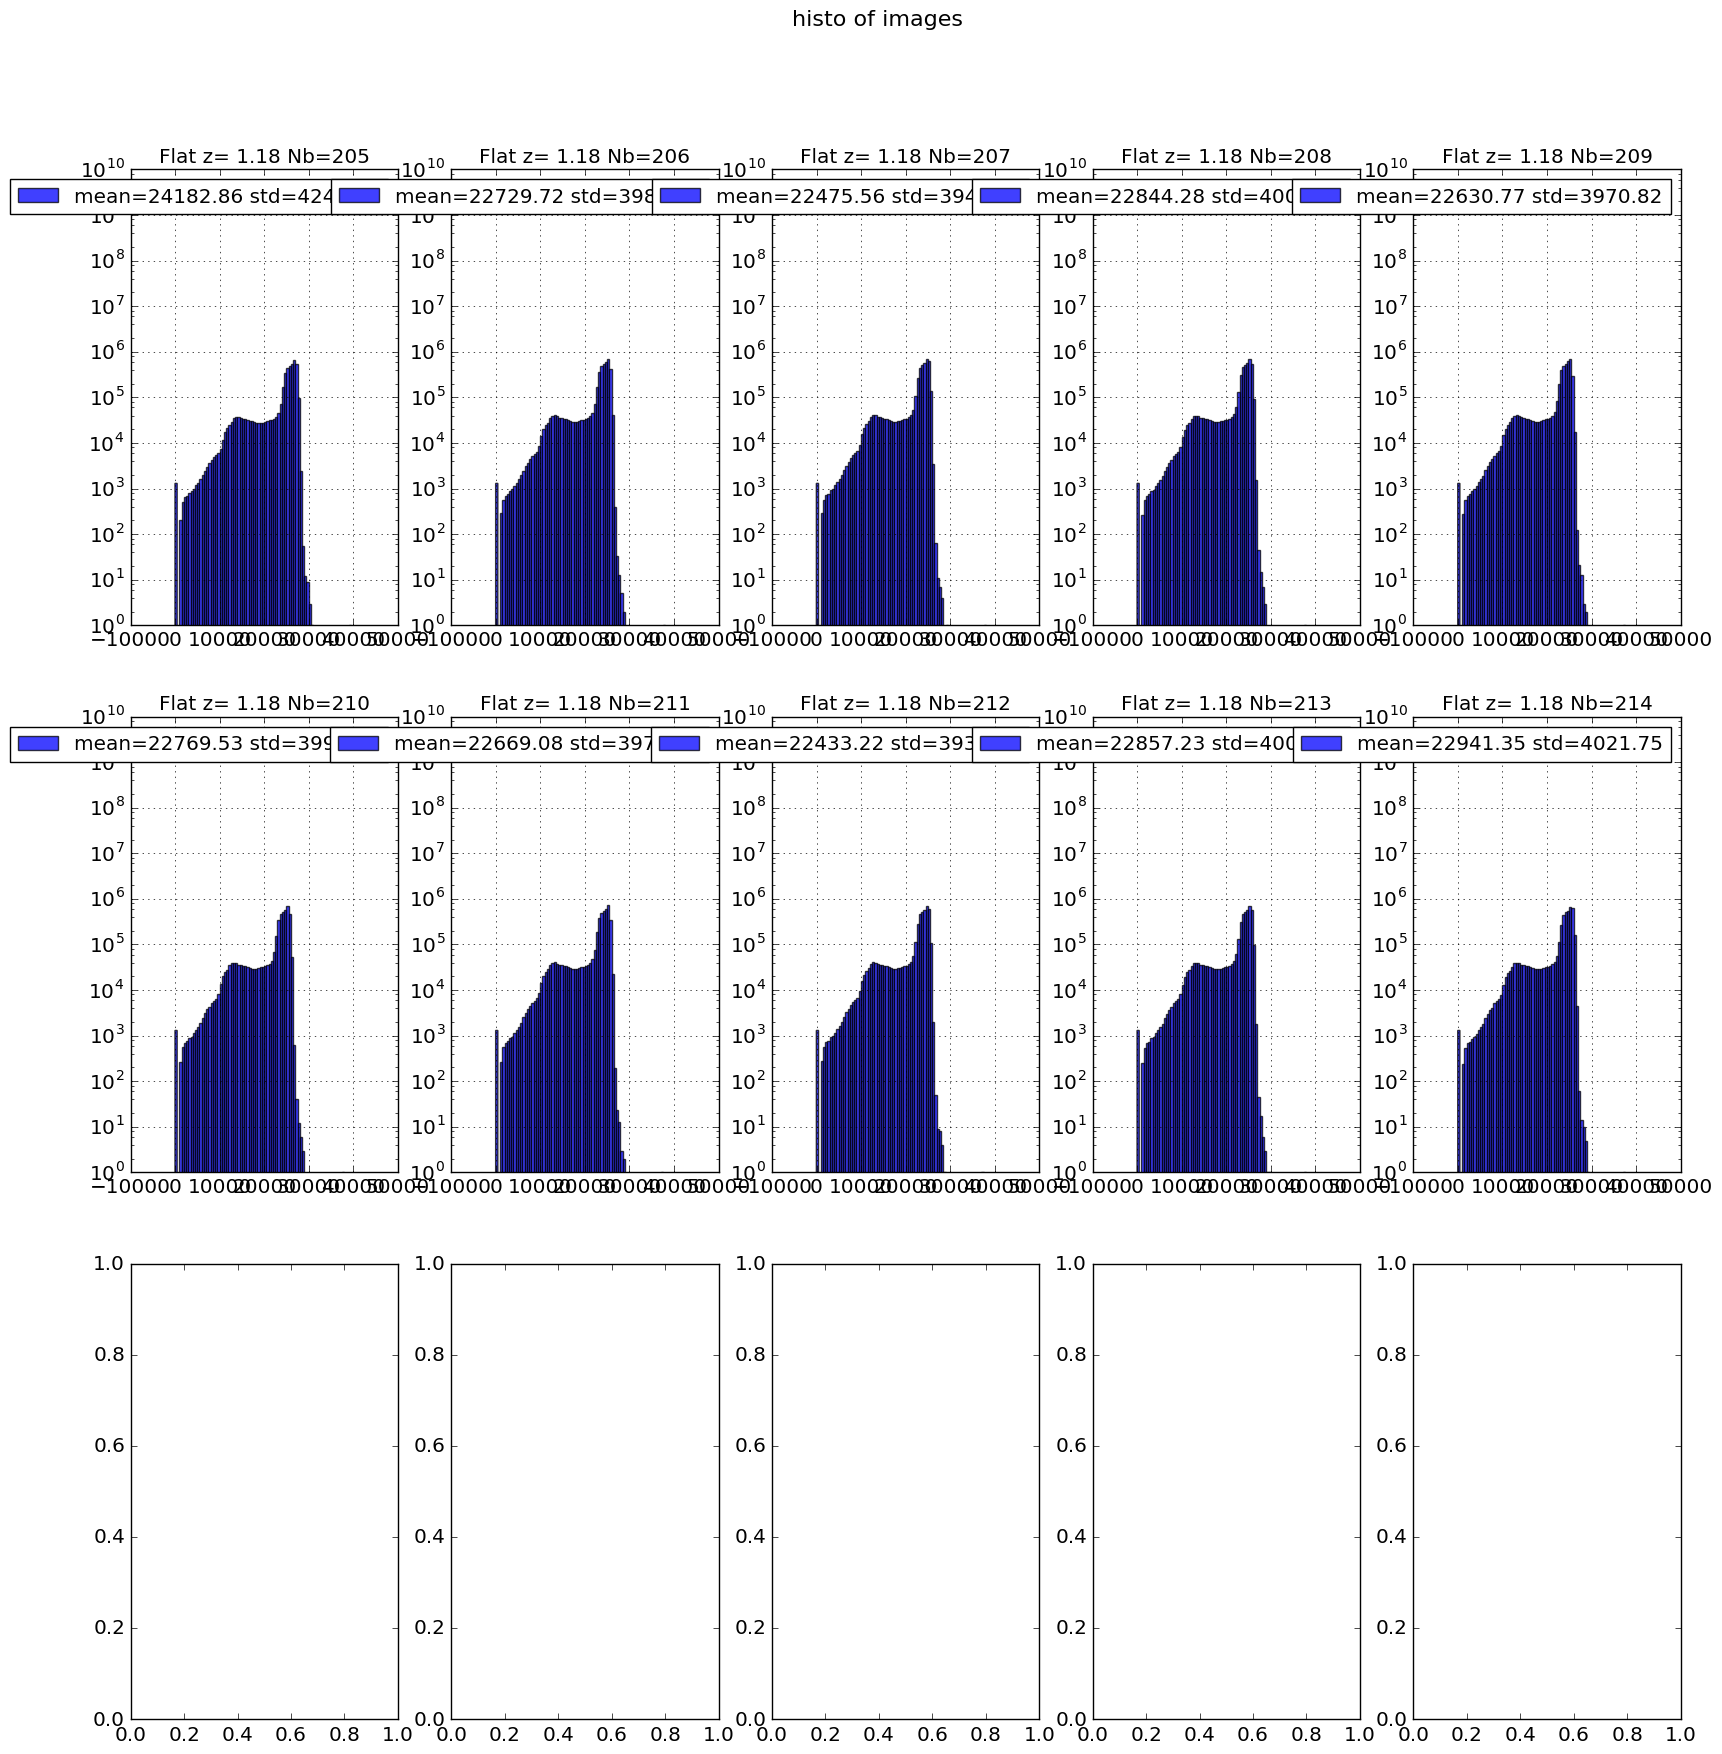

In [49]:
ShowHistograms()

## Transfer the image in CCDData
====================================

In [50]:
NBIMAGES=len(all_images)
all_rawflat = []
for index in np.arange(0,NBIMAGES):
    rawflat=ccdproc.CCDData(all_images[index],unit='adu')
    all_rawflat.append(rawflat)

In [51]:
all_flat_bias_subtracted = []
for flat in all_rawflat:
    flat_bias_subtracted = ccdproc.subtract_bias(flat,master_bias,add_keyword={'calib': 'subtracted bias'})
    all_flat_bias_subtracted.append(flat_bias_subtracted)

## Make Master Flat
============================

In [52]:
flat_combiner = Combiner(all_flat_bias_subtracted)

In [53]:
flat_combiner.sigma_clipping(func=med_over_images)

In [54]:
#scaling_func = lambda arr: 1/np.ma.average(arr)
scaling_func= lambda arr: 1/np.ma.median(arr)
flat_combiner.scaling = scaling_func

In [55]:
master_flat = flat_combiner.median_combine(median_func=bn_median)

## Result on Master Flat
===============================

In [56]:
flat_min, flat_max, flat_mean, flat_std = imstats(np.asarray(master_flat))

In [57]:
print flat_min, flat_max, flat_mean, flat_std

-0.000976289374583 2.44201980524 0.940702100826 0.164841970084


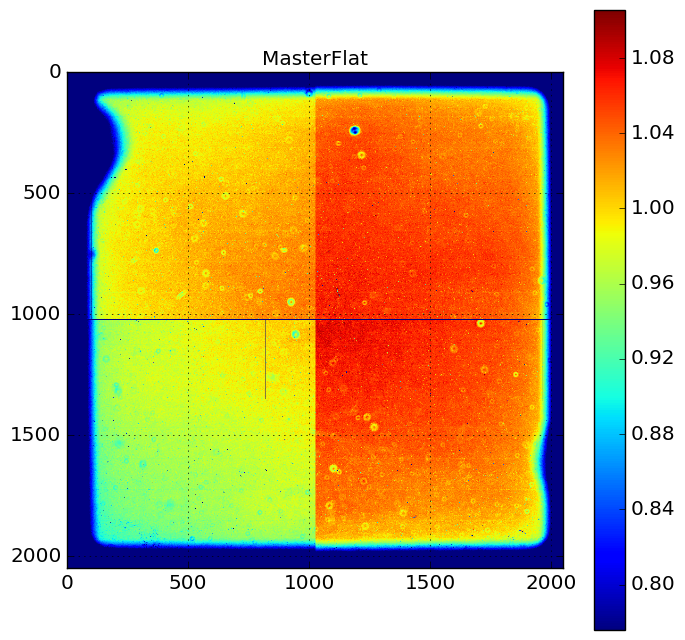

In [58]:
plt.figure(figsize=(8, 8))
#plt.imshow(master_bias, vmax=bias_mean + bias_std, vmin=bias_mean - bias_std)
plt.imshow(master_flat, vmax=flat_mean+1*flat_std, vmin=flat_mean-1*flat_std)
plt.grid(True)
plt.colorbar()
plt.title('MasterFlat')

In [59]:
flatten_flat=master_flat.data.flatten()

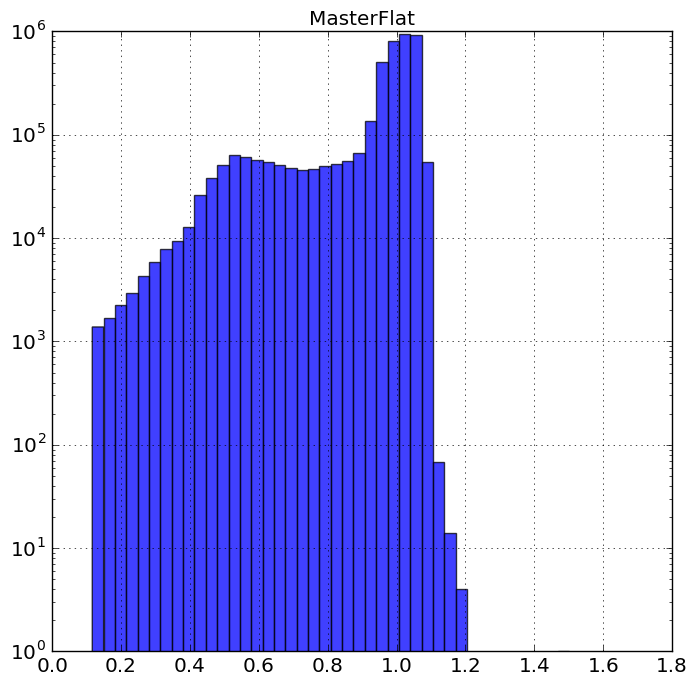

In [60]:
plt.hist(flatten_flat,bins=50,range=(flat_mean-5*flat_std,flat_mean+5*flat_std),facecolor='blue', alpha=0.75);
plt.yscale('log')
plt.grid(True)
plt.title('MasterFlat')

## Save the Master Flat
----------------------------------------------------------

In [61]:
prihdu = fits.PrimaryHDU(header=all_header[0],data=master_flat.data)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfile,clobber=True)

NameError: name 'outputfile' is not defined

In [ ]:
!ls